## Simple Variational Autoencoder for MNIST Generation

Based on the following paper: <i>Auto-Encoding Variational Bayes</i>; this is a good [guide](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73).

In [1]:
from tensorflow.keras.layers import Dense,Flatten,Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.set_floatx('float32')
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.enable_eager_execution()

In [2]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape,y_train.shape # pre-shuffled

((60000, 28, 28), (60000,))

In [3]:
x_train = x_train[y_train <= 3]
y_train = y_train[y_train <= 3]
x_train = x_train.astype("float32")
print(x_train.shape,y_train.shape,y_train[:10])

(24754, 28, 28) (24754,) [0 1 2 1 3 1 3 3 1 2]


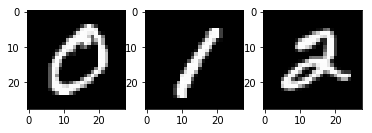

In [4]:
plt.subplot(1,3,1)
plt.imshow(x_train[0],cmap="gray")
plt.subplot(1,3,2)
plt.imshow(x_train[1],cmap="gray")
plt.subplot(1,3,3)
plt.imshow(x_train[2],cmap="gray")
plt.show()

In [5]:
x_train.shape = (len(x_train),784)

In [12]:
def vae():
    """ encoder and decoder for VAE
    """
    x = Input(shape=(784))
    r = Input(shape=(32)) # the random component ~N(0,1)
    # encoder
    h1 = Dense(128,activation="relu")(x) # shared layer
    h2 = Dense(64,activation="relu")(h1)
    h = Dense(32,activation=None)(h2) # for Sigma
    h = tf.sqrt(tf.square(h)) # sigma must be positive
    g2 = Dense(64,activation="relu")(h1)
    g = Dense(32,activation=None)(g2) # for Mu
    z = g + h*r # re-parametarization (sample from latent space, L=1), z.shape:(N,32)
    # decoder
    f1 = Dense(64,activation="relu")(z)
    f2 = Dense(128,activation="relu")(f1)
    f = Dense(784,activation=None)(f2)
    
    model = Model(inputs=[x,r],outputs=[f,g,h])
    return model

In [13]:
def vae_cost(x,f,g,h):
    """ latent_loss + reconstruction_loss
    """
    g = g**2 # Mu
    h = h**2 # Sigma
    latent_loss = 1 + tf.log(h) - g - h # (N,32)
    latent_loss = -0.5*tf.reduce_sum(latent_loss,axis=-1) # closed form, from KL divergence
    reconstruction_loss = tf.keras.losses.MSE(x,f) # MSE for measuring reconstruction
    total_loss = tf.reduce_sum(latent_loss + reconstruction_loss,axis=0)
    return total_loss

In [14]:
model = vae()

In [26]:
optimizer = Adam(0.001)

In [29]:
# displaying loss values after earlier training
for epoch in range(50): # training the model, num. epochs
    losses = []
    for i in range(0,len(x_train)-100,100): # batch size of 100
        x = x_train[i:i+100]
        r = np.random.normal(loc=0.0,scale=1.0,size=(100,32)).astype("float32")
        with tf.GradientTape() as tape:
            f,g,h = model([x,r]) # prediction/decoding
            loss = vae_cost(x,f,g,h)
        losses.append(float(loss))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    print("epoch {} loss: {}".format(epoch+1,sum(losses)/len(losses)))

epoch 1 loss: 178308.05819838058
epoch 2 loss: 178111.1140561741
epoch 3 loss: 177845.85304908906
epoch 4 loss: 177502.07376012145
epoch 5 loss: 177412.20628795546
epoch 6 loss: 177165.4726720648
epoch 7 loss: 176926.38739878542
epoch 8 loss: 176744.41599190285
epoch 9 loss: 176494.76189271256
epoch 10 loss: 176494.08755060728
epoch 11 loss: 176180.71792763157
epoch 12 loss: 175917.01113360323
epoch 13 loss: 175764.18857540487
epoch 14 loss: 175583.1005187247
epoch 15 loss: 175403.57660678137
epoch 16 loss: 175223.18237601215
epoch 17 loss: 175115.56547317814
epoch 18 loss: 174830.08609564777
epoch 19 loss: 174716.87411437248
epoch 20 loss: 174550.39347165992
epoch 21 loss: 174497.06003289475
epoch 22 loss: 174319.37664473685
epoch 23 loss: 174122.83046558703
epoch 24 loss: 173925.25056933198
epoch 25 loss: 173826.29719129554
epoch 26 loss: 173753.12594888665
epoch 27 loss: 173644.05086032388
epoch 28 loss: 173417.1391700405
epoch 29 loss: 173489.0605389676
epoch 30 loss: 173187.475835

In [6]:
model = tf.keras.models.load_model('my_model.h5')

In [19]:
def generate_example(i):
    x = x_train[i]
    x = np.expand_dims(x,axis=0)
    r1 = np.random.normal(loc=0.0,scale=1.0,size=(1,32)).astype("float32")
    r2 = np.random.normal(loc=0.0,scale=1.0,size=(1,32)).astype("float32")
    f1,_,_ = model([x,r1])
    f2,_,_ = model([x,r2])
    pred1 = np.maximum(0,f1.numpy())
    pred2 = np.maximum(0,f2.numpy())
    pred1.shape = (28,28) ; pred2.shape = (28,28) ; x.shape = (28,28)
    plt.subplot(1,3,1)
    plt.imshow(x,cmap="gray")
    plt.subplot(1,3,2)
    plt.imshow(pred1,cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(pred2,cmap="gray")
    plt.show()

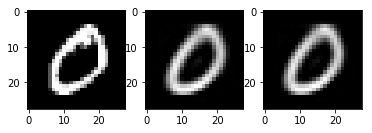

In [20]:
generate_example(0)

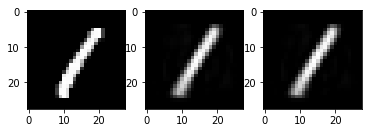

In [21]:
generate_example(1)

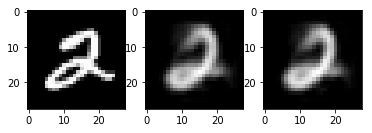

In [22]:
generate_example(2)

In [23]:
decoder = tf.keras.models.Sequential()

In [26]:
decoder.add(Input(32)) # extracting just the decoder portion of the model
decoder.add(model.layers[-3])
decoder.add(model.layers[-2])
decoder.add(model.layers[-1])

In [27]:
decoder.layers

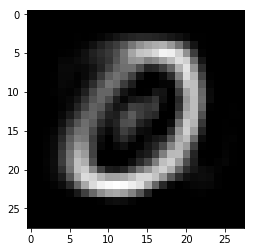

In [30]:
ainput = np.random.normal(loc=0.0,scale=1.0,size=(1,32)).astype("float32")
aoutput = decoder(ainput)
aoutput = aoutput.numpy()
aoutput.shape = (28,28)
aoutput = np.maximum(0,aoutput)
plt.imshow(aoutput,cmap="gray")
plt.show()

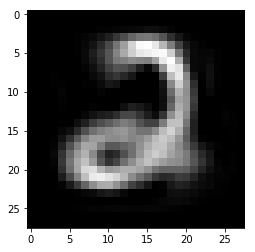

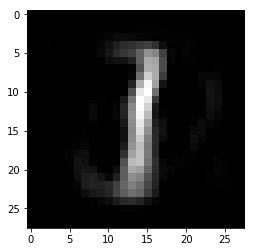

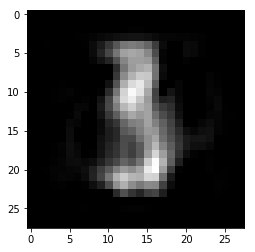

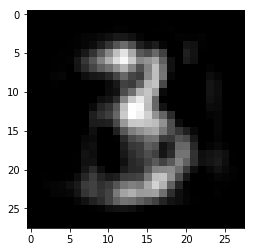